In [1]:
#loading require python packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils.np_utils import to_categorical

from keras.layers import  MaxPooling2D
from keras.layers import Convolution2D

Using TensorFlow backend.
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
le = LabelEncoder()

In [3]:
#function to read and return different dataset features and labels from given dataset name for example it will read either
#diagnosis or pronosis dataset
def readDataset(name):
    dataset = pd.read_csv(name)
    dataset.fillna(0, inplace = True)
    dataset.drop(['id'], axis = 1,inplace=True)
    dataset['diagnosis'] = pd.Series(le.fit_transform(dataset['diagnosis'].astype(str)))
    dataset = dataset.values
    Y = dataset[:,0]
    X = dataset[:,1:dataset.shape[1]-1]
    X = normalize(X)
    return X, Y

In [4]:
#using SMOTE class we will upsample all those class instances which are undersample and return new generated sample data
def upsampling(X, Y):
    sm = SMOTE(random_state = 2) #defining smote object
    upsample_X, upsample_Y = sm.fit_sample(X, Y)
    return upsample_X, upsample_Y


In [5]:
#this function used to split dataset into train and test
def trainTestSplit(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [6]:
#train the model
def trainDeepLearning(ensemble_X_train,ensemble_X_test,ensemble_y_train,ensemble_y_test):
    xtrain = ensemble_X_train.reshape(ensemble_X_train.shape[0], ensemble_X_train.shape[1], 1, 1)
    ytrain = to_categorical(ensemble_y_train)
    ytest = to_categorical(ensemble_y_test)
    xtest = ensemble_X_test.reshape(ensemble_X_test.shape[0], ensemble_X_test.shape[1], 1, 1)
    
    dl_model = Sequential()
    dl_model.add(Convolution2D(32, 1, 1, input_shape = (xtrain.shape[1], xtrain.shape[2], xtrain.shape[3]), activation = 'relu'))
    dl_model.add(MaxPooling2D(pool_size = (1, 1)))
    dl_model.add(Convolution2D(32, 1, 1, activation = 'relu'))
    dl_model.add(MaxPooling2D(pool_size = (1, 1)))
    dl_model.add(Flatten())
    dl_model.add(Dense(output_dim = 256, activation = 'relu'))
    dl_model.add(Dense(output_dim = ytrain.shape[1], activation = 'softmax'))
    dl_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    dl_model.fit(xtrain, ytrain, batch_size=16,epochs=10, validation_data=(xtest, ytest))
    predict = dl_model.predict(xtest)
    predict = np.argmax(predict, axis=1)
    ytest = np.argmax(ytest, axis=1)
    accuracy = accuracy_score(predict, ytest)
    return accuracy, predict

In [7]:
#this function is used to train and test ANN algortihm
def trainANN(ensemble_X_train,ensemble_X_test,ensemble_y_train,ensemble_y_test):
    ytrain = to_categorical(ensemble_y_train)
    ytest = to_categorical(ensemble_y_test)
    X_train, X_test, y_train, y_test = train_test_split(ensemble_X_train,ytrain, test_size=0.1, random_state=0)
    ann_model = Sequential()
    ann_model.add(Dense(512, input_shape=(ensemble_X_train.shape[1],)))
    ann_model.add(Activation('relu'))
    ann_model.add(Dropout(0.3))
    ann_model.add(Dense(512))
    ann_model.add(Activation('relu'))
    ann_model.add(Dropout(0.3))
    ann_model.add(Dense(ytrain.shape[1]))
    ann_model.add(Activation('softmax'))
    ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    ann_model.fit(ensemble_X_train, ytrain, batch_size=16,epochs=1, validation_data=(X_test, y_test))
    predict = ann_model.predict(X_test)
    predict = np.argmax(predict, axis=1)
    y_test = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(predict, y_test)
    return accuracy, predict

In [8]:
#this function will takes list of ensemble classifiers and then build stack classifier and then train on given input
#dataset and predicted values of this ensemble will get retrain with ANN
def train(X_train, X_test, y_train, y_test, ensembles):
    stacking = StackingClassifier(estimators = ensembles) #creating stack with list of ensembles and then train
    stacking.fit(X_train, y_train)
    predict = stacking.predict(X_test)
    trainANN(X_train, X_test, y_train, predict)#with stacking predicted data ANN get trained
    accuracy = accuracy_score(predict, y_test)
    return accuracy, predict


In [9]:
#creating list of ensembles
ensemble1 = [('svm', SVC()), ('lr', LogisticRegression()), ('nb', GaussianNB()), ('dt', DecisionTreeClassifier())]
ensemble2 = [('svm', SVC()), ('lr', LogisticRegression()), ('nb', GaussianNB()), ('rf', RandomForestClassifier())]
ensemble3 = [('svm', SVC()), ('lr', LogisticRegression()), ('rf', RandomForestClassifier()), ('dt', DecisionTreeClassifier())]
ensemble4 = [('svm', SVC()), ('lr', LogisticRegression()), ('rf', RandomForestClassifier()), ('nb', GaussianNB())]
ensemble5 = [('svm', SVC()), ('lr', LogisticRegression()), ('rf', RandomForestClassifier())]
ensemble6 = [('svm', SVC()), ('lr', LogisticRegression())]


In [10]:
#now reading dataset from both dataset files
diagnosis_X, diagnosis_Y = readDataset("Dataset/diagnostic_data.csv")
prognostic_X, prognostic_Y = readDataset("Dataset/prognostic_data.csv")

diagnosis_X_upsample, diagnosis_Y_upsample = upsampling(diagnosis_X, diagnosis_Y)
prognostic_X_upsample, prognostic_Y_upsample = upsampling(prognostic_X, prognostic_Y)
print()
print("Dataset reading completed")
print("Total records found in Diagnostic dataset without sampling : "+str(diagnosis_X.shape[0]))
print("Total records found in Diagnostic dataset with sampling : "+str(diagnosis_X_upsample.shape[0]))
print("Total records found in prognostic dataset without sampling : "+str(prognostic_X.shape[0]))
print("Total records found in prognostic dataset with sampling : "+str(prognostic_X_upsample.shape[0]))
print()


Dataset reading completed
Total records found in Diagnostic dataset without sampling : 569
Total records found in Diagnostic dataset with sampling : 714
Total records found in prognostic dataset without sampling : 569
Total records found in prognostic dataset with sampling : 714



In [11]:
#now splitting both datasets with and without sampling
diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test = trainTestSplit(diagnosis_X, diagnosis_Y)
prognostic_X_train, prognostic_X_test, prognostic_y_train, prognostic_y_test = trainTestSplit(prognostic_X, prognostic_Y)

upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test = trainTestSplit(diagnosis_X_upsample, diagnosis_Y_upsample)
upsample_prognostic_X_train, upsample_prognostic_X_test, upsample_prognostic_y_train, upsample_prognostic_y_test = trainTestSplit(prognostic_X_upsample, prognostic_Y_upsample)
print()
print("Diagnosis Train Data without sampling : "+str(diagnosis_X_train.shape[0])+"\nTest data without sampling : "+str(diagnosis_X_test.shape[0]))
print("Prognostic Train Data without sampling : "+str(prognostic_X_train.shape[0])+"\nTest data without sampling : "+str(prognostic_X_test.shape[0]))

print("Diagnosis Train Data with sampling : "+str(upsample_diagnosis_X_train.shape[0])+"\nTest data without sampling : "+str(upsample_diagnosis_X_test.shape[0]))
print("Prognostic Train Data with sampling : "+str(upsample_prognostic_X_train.shape[0])+"\nTest data without sampling : "+str(upsample_prognostic_X_test.shape[0]))
print()


Diagnosis Train Data without sampling : 455
Test data without sampling : 114
Prognostic Train Data without sampling : 455
Test data without sampling : 114
Diagnosis Train Data with sampling : 571
Test data without sampling : 143
Prognostic Train Data with sampling : 571
Test data without sampling : 143



In [12]:
#now train both dataset with various ensemble algorithms
svm_lr_nb_dt_ann_accuracy_no_upsample_diag, predict1 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble1)
svm_lr_nb_dt_ann_accuracy_upsample_diag, predict2 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble1)
                 
svm_lr_nb_dt_ann_accuracy_no_upsample_prog, predict3 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble1)
svm_lr_nb_dt_ann_accuracy_upsample_prog, predict4 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble1)


svm_lr_nb_rf_ann_accuracy_no_upsample_diag, predict5 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble2)
svm_lr_nb_rf_ann_accuracy_upsample_diag, predict6 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble2)
                 
svm_lr_nb_rf_ann_accuracy_no_upsample_prog, predict7 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble2)
svm_lr_nb_rf_ann_accuracy_upsample_prog, predict8 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble2)


svm_lr_rf_dt_ann_accuracy_no_upsample_diag, predict9 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble3)
svm_lr_rf_dt_ann_accuracy_upsample_diag, predict10 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble3)
                 
svm_lr_rf_dt_ann_accuracy_no_upsample_prog, predict11 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble3)
svm_lr_rf_dt_ann_accuracy_upsample_prog, predict12 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble3)


svm_lr_rf_nb_ann_accuracy_no_upsample_diag, predict13 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble4)
svm_lr_rf_nb_ann_accuracy_upsample_diag, predict14 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble4)
                 
svm_lr_rf_nb_ann_accuracy_no_upsample_prog, predict15 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble4)
svm_lr_rf_nb_ann_accuracy_upsample_prog, predict16 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble4)


svm_lr_rf_ann_accuracy_no_upsample_diag, predict17 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble5)
svm_lr_rf_ann_accuracy_upsample_diag, predict18 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble5)
                 
svm_lr_rf_ann_accuracy_no_upsample_prog, predict19 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble5)
svm_lr_rf_ann_accuracy_upsample_prog, predict20 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble5)


svm_lr_ann_accuracy_no_upsample_diag, predict21 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble6)
svm_lr_ann_accuracy_upsample_diag, predict22 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble6)
                 
svm_lr_ann_accuracy_no_upsample_prog, predict23 = train(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test, ensemble6)
svm_lr_ann_accuracy_upsample_prog, predict24 = train(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test, ensemble6)


dl_nosample_diag_accuracy, dl_predict1 = trainDeepLearning(diagnosis_X_train, diagnosis_X_test, diagnosis_y_train, diagnosis_y_test)
dl_sample_diag_accuracy, dl_predict2 = trainDeepLearning(upsample_diagnosis_X_train, upsample_diagnosis_X_test, upsample_diagnosis_y_train, upsample_diagnosis_y_test)

dl_nosample_prog_accuracy, dl_predict3 = trainDeepLearning(prognostic_X_train, prognostic_X_test, prognostic_y_train, prognostic_y_test)
dl_sample_prog_accuracy, dl_predict4 = trainDeepLearning(upsample_prognostic_X_train, upsample_prognostic_X_test, upsample_prognostic_y_train, upsample_prognostic_y_test)
print("****************************************************************************************************")
print("Training Comleted")
print("****************************************************************************************************")


Train on 455 samples, validate on 46 samples
Epoch 1/1
455/455 [==============================] - 1s 2ms/step - loss: 0.6339 - accuracy: 0.6220 - val_loss: 0.5827 - val_accuracy: 0.6957
Train on 571 samples, validate on 58 samples
Epoch 1/1
571/571 [==============================] - 0s 561us/step - loss: 0.6614 - accuracy: 0.5657 - val_loss: 0.6132 - val_accuracy: 0.6379
Train on 455 samples, validate on 46 samples
Epoch 1/1
455/455 [==============================] - 0s 701us/step - loss: 0.6449 - accuracy: 0.6198 - val_loss: 0.5862 - val_accuracy: 0.7391
Train on 571 samples, validate on 58 samples
Epoch 1/1
571/571 [==============================] - 0s 602us/step - loss: 0.6601 - accuracy: 0.6375 - val_loss: 0.6150 - val_accuracy: 0.5690
Train on 455 samples, validate on 46 samples
Epoch 1/1
455/455 [==============================] - 0s 815us/step - loss: 0.6398 - accuracy: 0.6484 - val_loss: 0.5947 - val_accuracy: 0.6522
Train on 571 samples, validate on 58 samples
Epoch 1/1
571/57

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(30, 1, 1), activation="relu")`
  if __name__ == "__main__":
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`
  from ipykernel import kernelapp as app


Train on 455 samples, validate on 114 samples
Epoch 1/10
455/455 [==============================] - 1s 2ms/step - loss: 0.6528 - accuracy: 0.6330 - val_loss: 0.6686 - val_accuracy: 0.5877
Epoch 2/10
455/455 [==============================] - 0s 342us/step - loss: 0.6368 - accuracy: 0.6374 - val_loss: 0.6453 - val_accuracy: 0.5877
Epoch 3/10
455/455 [==============================] - 0s 318us/step - loss: 0.6057 - accuracy: 0.6374 - val_loss: 0.6006 - val_accuracy: 0.5965
Epoch 4/10
455/455 [==============================] - 0s 322us/step - loss: 0.5469 - accuracy: 0.6967 - val_loss: 0.5172 - val_accuracy: 0.7807
Epoch 5/10
455/455 [==============================] - 0s 331us/step - loss: 0.4544 - accuracy: 0.8396 - val_loss: 0.4022 - val_accuracy: 0.8596
Epoch 6/10
455/455 [==============================] - 0s 330us/step - loss: 0.3400 - accuracy: 0.8879 - val_loss: 0.2931 - val_accuracy: 0.9211
Epoch 7/10
455/455 [==============================] - 0s 311us/step - loss: 0.2817 - accurac

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(30, 1, 1), activation="relu")`
  if __name__ == "__main__":
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`
  from ipykernel import kernelapp as app


Train on 571 samples, validate on 143 samples
Epoch 1/10
571/571 [==============================] - 1s 990us/step - loss: 0.6696 - accuracy: 0.6900 - val_loss: 0.6218 - val_accuracy: 0.7692
Epoch 2/10
571/571 [==============================] - 0s 347us/step - loss: 0.5478 - accuracy: 0.8004 - val_loss: 0.4338 - val_accuracy: 0.8951
Epoch 3/10
571/571 [==============================] - 0s 318us/step - loss: 0.3747 - accuracy: 0.8529 - val_loss: 0.2848 - val_accuracy: 0.8951
Epoch 4/10
571/571 [==============================] - 0s 297us/step - loss: 0.2714 - accuracy: 0.8949 - val_loss: 0.2499 - val_accuracy: 0.8951
Epoch 5/10
571/571 [==============================] - 0s 315us/step - loss: 0.2499 - accuracy: 0.9054 - val_loss: 0.2198 - val_accuracy: 0.9021
Epoch 6/10
571/571 [==============================] - 0s 306us/step - loss: 0.2530 - accuracy: 0.9037 - val_loss: 0.2604 - val_accuracy: 0.8741
Epoch 7/10
571/571 [==============================] - 0s 302us/step - loss: 0.2346 - accur

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(30, 1, 1), activation="relu")`
  if __name__ == "__main__":
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`
  from ipykernel import kernelapp as app


Train on 455 samples, validate on 114 samples
Epoch 1/10
455/455 [==============================] - 1s 1ms/step - loss: 0.6556 - accuracy: 0.6374 - val_loss: 0.6673 - val_accuracy: 0.5877
Epoch 2/10
455/455 [==============================] - 0s 364us/step - loss: 0.6265 - accuracy: 0.6374 - val_loss: 0.6359 - val_accuracy: 0.5877
Epoch 3/10
455/455 [==============================] - 0s 361us/step - loss: 0.5872 - accuracy: 0.6989 - val_loss: 0.5932 - val_accuracy: 0.5965
Epoch 4/10
455/455 [==============================] - 0s 357us/step - loss: 0.5168 - accuracy: 0.7604 - val_loss: 0.4745 - val_accuracy: 0.7632
Epoch 5/10
455/455 [==============================] - 0s 348us/step - loss: 0.3874 - accuracy: 0.8681 - val_loss: 0.3229 - val_accuracy: 0.9386
Epoch 6/10
455/455 [==============================] - 0s 352us/step - loss: 0.2942 - accuracy: 0.8945 - val_loss: 0.3692 - val_accuracy: 0.8333
Epoch 7/10
455/455 [==============================] - 0s 357us/step - loss: 0.2497 - accurac

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(30, 1, 1), activation="relu")`
  if __name__ == "__main__":
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`
  from ipykernel import kernelapp as app


Train on 571 samples, validate on 143 samples
Epoch 1/10
571/571 [==============================] - 1s 1ms/step - loss: 0.6686 - accuracy: 0.6602 - val_loss: 0.6318 - val_accuracy: 0.6783
Epoch 2/10
571/571 [==============================] - 0s 359us/step - loss: 0.5618 - accuracy: 0.7688 - val_loss: 0.4629 - val_accuracy: 0.9301
Epoch 3/10
571/571 [==============================] - 0s 333us/step - loss: 0.3817 - accuracy: 0.8739 - val_loss: 0.2989 - val_accuracy: 0.8881
Epoch 4/10
571/571 [==============================] - 0s 338us/step - loss: 0.2962 - accuracy: 0.8757 - val_loss: 0.2629 - val_accuracy: 0.8741
Epoch 5/10
571/571 [==============================] - 0s 324us/step - loss: 0.2662 - accuracy: 0.8809 - val_loss: 0.2301 - val_accuracy: 0.9091
Epoch 6/10
571/571 [==============================] - 0s 315us/step - loss: 0.2364 - accuracy: 0.9107 - val_loss: 0.2278 - val_accuracy: 0.8951
Epoch 7/10
571/571 [==============================] - 0s 308us/step - loss: 0.2710 - accurac

In [13]:
#training xgboost extension algortihm on both datasets with and without up-samples
from xgboost import XGBClassifier
diagnosis_xgb = XGBClassifier()
diagnosis_xgb.fit(diagnosis_X_train, diagnosis_y_train)
predict = diagnosis_xgb.predict(diagnosis_X_test)
diagnosis_no_sample_accuracy = accuracy_score(predict, diagnosis_y_test)

diagnosis_sample_xgb = XGBClassifier()
diagnosis_sample_xgb.fit(diagnosis_X_upsample, diagnosis_Y_upsample)
predict = diagnosis_sample_xgb.predict(upsample_diagnosis_X_test)
diagnosis_sample_accuracy = accuracy_score(predict, upsample_diagnosis_y_test)

prognosis_xgb = XGBClassifier()
prognosis_xgb.fit(prognostic_X_train, prognostic_y_train)
predict = prognosis_xgb.predict(prognostic_X_test)
prognosis_no_sample_accuracy = accuracy_score(predict, prognostic_y_test)

prognosis_sample_xgb = XGBClassifier()
prognosis_sample_xgb.fit(prognostic_X_upsample, prognostic_Y_upsample)
predict = prognosis_sample_xgb.predict(upsample_prognostic_X_test)
prognosis_sample_accuracy = accuracy_score(predict, upsample_prognostic_y_test)
print("XGBOOST Extension Training Completed")

XGBOOST Extension Training Completed


In [14]:
from IPython.display import display
acc = [
    ['(SVM+LR+NB+DT)+ANN', svm_lr_nb_dt_ann_accuracy_no_upsample_diag, svm_lr_nb_dt_ann_accuracy_upsample_diag, svm_lr_nb_dt_ann_accuracy_no_upsample_prog, svm_lr_nb_dt_ann_accuracy_upsample_prog],
    ['(SVM+LR+NB+RF)+ANN', svm_lr_nb_rf_ann_accuracy_no_upsample_diag, svm_lr_nb_rf_ann_accuracy_upsample_diag, svm_lr_nb_rf_ann_accuracy_no_upsample_prog, svm_lr_nb_rf_ann_accuracy_upsample_prog],
    ['(SVM+LR+RF+DT)+ANN', svm_lr_rf_dt_ann_accuracy_no_upsample_diag, svm_lr_rf_dt_ann_accuracy_upsample_diag, svm_lr_rf_dt_ann_accuracy_no_upsample_prog,svm_lr_rf_dt_ann_accuracy_upsample_prog],
    ['(SVM+LR+RF+NB)+ANN', svm_lr_rf_nb_ann_accuracy_no_upsample_diag, svm_lr_rf_nb_ann_accuracy_upsample_diag, svm_lr_rf_nb_ann_accuracy_no_upsample_prog, svm_lr_rf_nb_ann_accuracy_upsample_prog],
    ['(SVM+LR+RF)+ANN', svm_lr_rf_ann_accuracy_no_upsample_diag, svm_lr_rf_ann_accuracy_upsample_diag, svm_lr_rf_ann_accuracy_no_upsample_prog, svm_lr_rf_ann_accuracy_upsample_prog],
    ['(SVM+LR)+ANN', svm_lr_ann_accuracy_no_upsample_diag, svm_lr_ann_accuracy_upsample_diag, svm_lr_ann_accuracy_no_upsample_prog,svm_lr_ann_accuracy_upsample_prog],
    ['Deep Learning', dl_nosample_diag_accuracy, dl_sample_diag_accuracy, dl_nosample_prog_accuracy, dl_sample_prog_accuracy],
    ['Extension XGBoost', diagnosis_no_sample_accuracy, diagnosis_sample_accuracy, prognosis_no_sample_accuracy, prognosis_sample_accuracy]]
      
columns = ['Algorithm Name', "Diagnosis Without Sampling", "Diagnosis With Sampling", "Prognosis Without Sampling", 'Prognosis With Sampling']
output = pd.DataFrame(acc, columns=columns)
display(output)

,Algorithm Name,Diagnosis Without Sampling,Diagnosis With Sampling,Prognosis Without Sampling,Prognosis With Sampling
0,(SVM+LR+NB+DT)+ANN,0.929825,0.979021,0.938596,0.965035
1,(SVM+LR+NB+RF)+ANN,0.947368,0.986014,0.947368,0.986014
2,(SVM+LR+RF+DT)+ANN,0.947368,0.979021,0.947368,0.972028
3,(SVM+LR+RF+NB)+ANN,0.947368,0.986014,0.956140,0.986014
4,(SVM+LR+RF)+ANN,0.947368,0.986014,0.947368,0.986014
5,(SVM+LR)+ANN,0.885965,0.895105,0.885965,0.895105
6,Deep Learning,0.929825,0.902098,0.877193,0.916084
7,Extension XGBoost,0.956140,1.000000,0.956140,1.000000


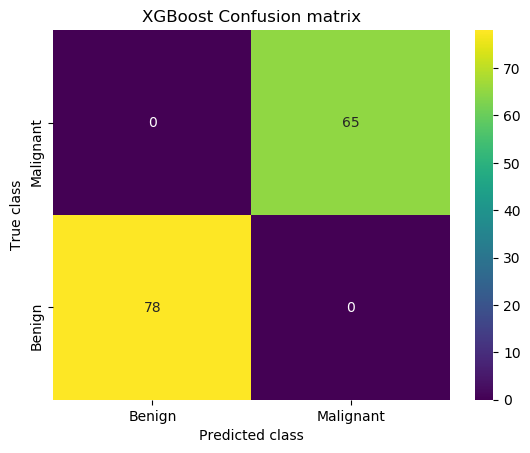

In [15]:
import matplotlib.pyplot as plt
labels = ["Benign", "Malignant"]
conf_matrix = confusion_matrix(upsample_prognostic_y_test, predict) 
#plt.figure(figsize =(6, 6)) 
ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
ax.set_ylim([0,len(labels)])
plt.title("XGBoost Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show()

In [16]:
labels = ['Benign', 'Malignant']
testData = pd.read_csv("Dataset/testData.csv")
testData.fillna(0, inplace = True)
temp = testData.values
testData = testData.values
testData = testData[:,0:testData.shape[1]-1]
testData = normalize(testData)
predict = diagnosis_sample_xgb.predict(testData)
for i in range(len(predict)):
    print("Test Data : "+str(temp[i])+" =====> Predicted As : "+str(labels[int(predict[i])]))
    print()

Test Data : [1.921e+01 1.857e+01 1.255e+02 1.152e+03 1.053e-01 1.267e-01 1.323e-01
 8.994e-02 1.917e-01 5.961e-02 7.275e-01 1.193e+00 4.837e+00 1.025e+02
 6.458e-03 2.306e-02 2.945e-02 1.538e-02 1.852e-02 2.608e-03 2.614e+01
 2.814e+01 1.701e+02 2.145e+03 1.624e-01 3.511e-01 3.879e-01 2.091e-01
 3.537e-01 8.294e-02 0.000e+00] =====> Predicted As : Malignant

Test Data : [1.471e+01 2.159e+01 9.555e+01 6.569e+02 1.137e-01 1.365e-01 1.293e-01
 8.123e-02 2.027e-01 6.758e-02 4.226e-01 1.150e+00 2.735e+00 4.009e+01
 3.659e-03 2.855e-02 2.572e-02 1.272e-02 1.817e-02 4.108e-03 1.787e+01
 3.070e+01 1.157e+02 9.855e+02 1.368e-01 4.290e-01 3.587e-01 1.834e-01
 3.698e-01 1.094e-01 0.000e+00] =====> Predicted As : Malignant

Test Data : [1.305e+01 1.931e+01 8.261e+01 5.272e+02 8.060e-02 3.789e-02 6.920e-04
 4.167e-03 1.819e-01 5.501e-02 4.040e-01 1.214e+00 2.595e+00 3.296e+01
 7.491e-03 8.593e-03 6.920e-04 4.167e-03 2.190e-02 2.990e-03 1.423e+01
 2.225e+01 9.024e+01 6.241e+02 1.021e-01 6.191e-02 1.